In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams["figure.figsize"] = (20, 3)
pd.options.display.float_format = '{:20,.4f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set(context="paper", font="monospace")

from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('SampleSubmission.csv')

In [3]:
to_drop = ['form_field3', 'form_field4', 'form_field8', 'form_field9', 'form_field8', 'form_field11', 'form_field12','form_field13', 'form_field14', 'form_field16', 'form_field17', 'form_field21', 'form_field23', 'form_field27', 'form_field30', 'form_field31', 'form_field32', 'form_field33', 'form_field35', 'form_field36', 'form_field39', 'form_field40', 'form_field41', 'form_field43', 'form_field44', 'form_field45', 'form_field46', 'form_field48', 'form_field49', 'form_field50']
train.drop(to_drop, inplace=True, axis=1)
test.drop(to_drop, inplace=True, axis=1)

In [4]:
test['default_status'] = 'test'
data = pd.concat([train, test]).reset_index(drop=True)

In [5]:
missing_col = data.columns[data.isna().any()]
missing_col

Index(['form_field1', 'form_field2', 'form_field5', 'form_field6',
       'form_field7', 'form_field10', 'form_field15', 'form_field18',
       'form_field19', 'form_field20', 'form_field22', 'form_field24',
       'form_field25', 'form_field26', 'form_field28', 'form_field29',
       'form_field34', 'form_field37', 'form_field38', 'form_field42'],
      dtype='object')

In [6]:
for col in missing_col:
    
    data[col].fillna(data[col].median(), inplace = True)

In [7]:
data.isnull().sum()

Applicant_ID      0
form_field1       0
form_field2       0
form_field5       0
form_field6       0
form_field7       0
form_field10      0
form_field15      0
form_field18      0
form_field19      0
form_field20      0
form_field22      0
form_field24      0
form_field25      0
form_field26      0
form_field28      0
form_field29      0
form_field34      0
form_field37      0
form_field38      0
form_field42      0
form_field47      0
default_status    0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Applicant_ID    80000 non-null  object 
 1   form_field1     80000 non-null  float64
 2   form_field2     80000 non-null  float64
 3   form_field5     80000 non-null  float64
 4   form_field6     80000 non-null  float64
 5   form_field7     80000 non-null  float64
 6   form_field10    80000 non-null  float64
 7   form_field15    80000 non-null  float64
 8   form_field18    80000 non-null  float64
 9   form_field19    80000 non-null  float64
 10  form_field20    80000 non-null  float64
 11  form_field22    80000 non-null  float64
 12  form_field24    80000 non-null  float64
 13  form_field25    80000 non-null  float64
 14  form_field26    80000 non-null  float64
 15  form_field28    80000 non-null  float64
 16  form_field29    80000 non-null  float64
 17  form_field34    80000 non-null 

In [9]:
from scipy.stats import skew,norm  # for some statistics

In [10]:
numeric = data.select_dtypes(include='number').columns
skew_features = data[numeric].apply(lambda x: skew(x)).sort_values(ascending=True)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features

There are 19 numerical features with Skew > 0.5 :


form_field1                  0.1248
form_field29                 0.9388
form_field28                 0.9911
form_field22                 1.1656
form_field42                 1.2129
form_field26                 1.6516
form_field25                 1.8046
form_field37                 2.1489
form_field38                 2.7596
form_field20                 3.1420
form_field19                 3.2760
form_field2                  4.5311
form_field18                 5.1708
form_field34                 5.9412
form_field6                  7.4445
form_field15                 7.9039
form_field5                 10.1979
form_field10                15.4462
form_field7                 33.3057
form_field24                41.6261
dtype: float64

In [11]:
# Normalize skewed features using log transformation
for column in skew_index:
    data[column] = np.log1p(data[column])

In [12]:
cat_features = data.select_dtypes(exclude=np.number).columns.drop('default_status')

In [13]:
cat_features

Index(['Applicant_ID', 'form_field47'], dtype='object')

In [14]:
data.drop('Applicant_ID',inplace=True,axis=1)

In [15]:
categorical_features = data.select_dtypes(exclude=np.number).columns.drop('default_status')

In [16]:
lbl = LabelEncoder()
data['form_field47'] = lbl.fit_transform(data['form_field47'])

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   form_field1     80000 non-null  float64
 1   form_field2     80000 non-null  float64
 2   form_field5     80000 non-null  float64
 3   form_field6     80000 non-null  float64
 4   form_field7     80000 non-null  float64
 5   form_field10    80000 non-null  float64
 6   form_field15    80000 non-null  float64
 7   form_field18    80000 non-null  float64
 8   form_field19    80000 non-null  float64
 9   form_field20    80000 non-null  float64
 10  form_field22    80000 non-null  float64
 11  form_field24    80000 non-null  float64
 12  form_field25    80000 non-null  float64
 13  form_field26    80000 non-null  float64
 14  form_field28    80000 non-null  float64
 15  form_field29    80000 non-null  float64
 16  form_field34    80000 non-null  float64
 17  form_field37    80000 non-null 

In [18]:
train_df = data.loc[( data['default_status'] != 'test')].reset_index(drop = True)
test_df = data.loc[( data['default_status'] == 'test')].reset_index(drop = True)

In [19]:
train_df.shape, test_df.shape

((56000, 22), (24000, 22))

In [20]:
X = train_df.drop('default_status', axis = 1)
y = train_df['default_status']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify = y,  random_state=42)

In [22]:
lr = LogisticRegression()
rf = RandomForestClassifier()
gbm = GradientBoostingClassifier()
decision_tree = DecisionTreeClassifier()

In [23]:
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
gbm.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [24]:
print('Logistic Regression Log loss: {}'.format(log_loss(y_test, lr.predict_proba(X_test)[:,1])))
print('RandomForestClassifier Log loss: {}'.format(log_loss(y_test, rf.predict_proba(X_test)[:,1])))
print('GradientBoostingClassifier Log loss: {}'.format(log_loss(y_test, gbm.predict_proba(X_test)[:,1])))
print('DecisionTreeClassifier Log loss: {}'.format(log_loss(y_test, decision_tree.predict_proba(X_test)[:,1])))

Logistic Regression Log loss: 0.4481360723937338
RandomForestClassifier Log loss: 0.440614585937586
GradientBoostingClassifier Log loss: 0.4138533870467833
DecisionTreeClassifier Log loss: 9.295364060538446


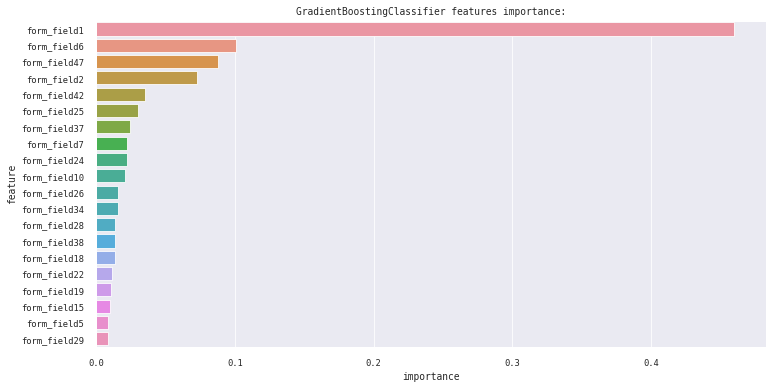

In [25]:
feature_importance_df = pd.DataFrame(gbm.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(12, 6));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(20))
plt.title('GradientBoostingClassifier features importance:');

In [26]:
accuracy = gbm.score(X_test, y_test)

In [27]:
accuracy

0.80875

In [28]:
test_x = test_df.drop('default_status', axis = 1)

In [29]:
prediction = gbm.predict_proba(test_x)[:, 1]